In [1]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import review_preprocess
import summarize_review
print("Setup Done...")

Setup Done...


### Loading dataset

In [3]:
train_file_name = 'drugsComTrain_raw.csv'
test_file_name = 'drugsComTest_raw.csv'
file_path = './data/'

df_test = pd.read_csv(file_path+test_file_name)
df_train = pd.read_csv(file_path+train_file_name)

In [4]:
#Look at our dataset
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


### Checking for NAN or na values

In [5]:
train_na = df_train.isna().values
np.argwhere(train_na==True).shape
print("rows with nan ", np.argwhere(train_na==True).shape[0])


rows with nan  899


### Figure out what colums have missing values

In [6]:
missing_indexes = np.argwhere(train_na==True)

# unique_cols with missing data
missing_cols = np.unique(missing_indexes[:,1])
for m_c in missing_cols:
    print('Index of missing columns ->', m_c, \
          '\nName of missing columns ->',df_train.columns[m_c],'\n\n')
# so we can see only column name condition is missing


Index of missing columns -> 2 
Name of missing columns -> condition 




In [7]:
# clean up reviews for garbage values and remove missing value rows
df_test = review_preprocess.clean_reviews(df_test)
df_train = review_preprocess.clean_reviews(df_train)

Review cleanup Completed...aracters from review column--> 100.0 percentage complete
Removing row with nan values
Percentage of nan rows in dataset--> 0.55 %
Removed 295 rows with na values
Review cleanup Completed...aracters from review column--> 100.0 percentage complete
Removing row with nan values
Percentage of nan rows in dataset--> 0.56 %
Removed 899 rows with na values


## Word cloud for all the reviews

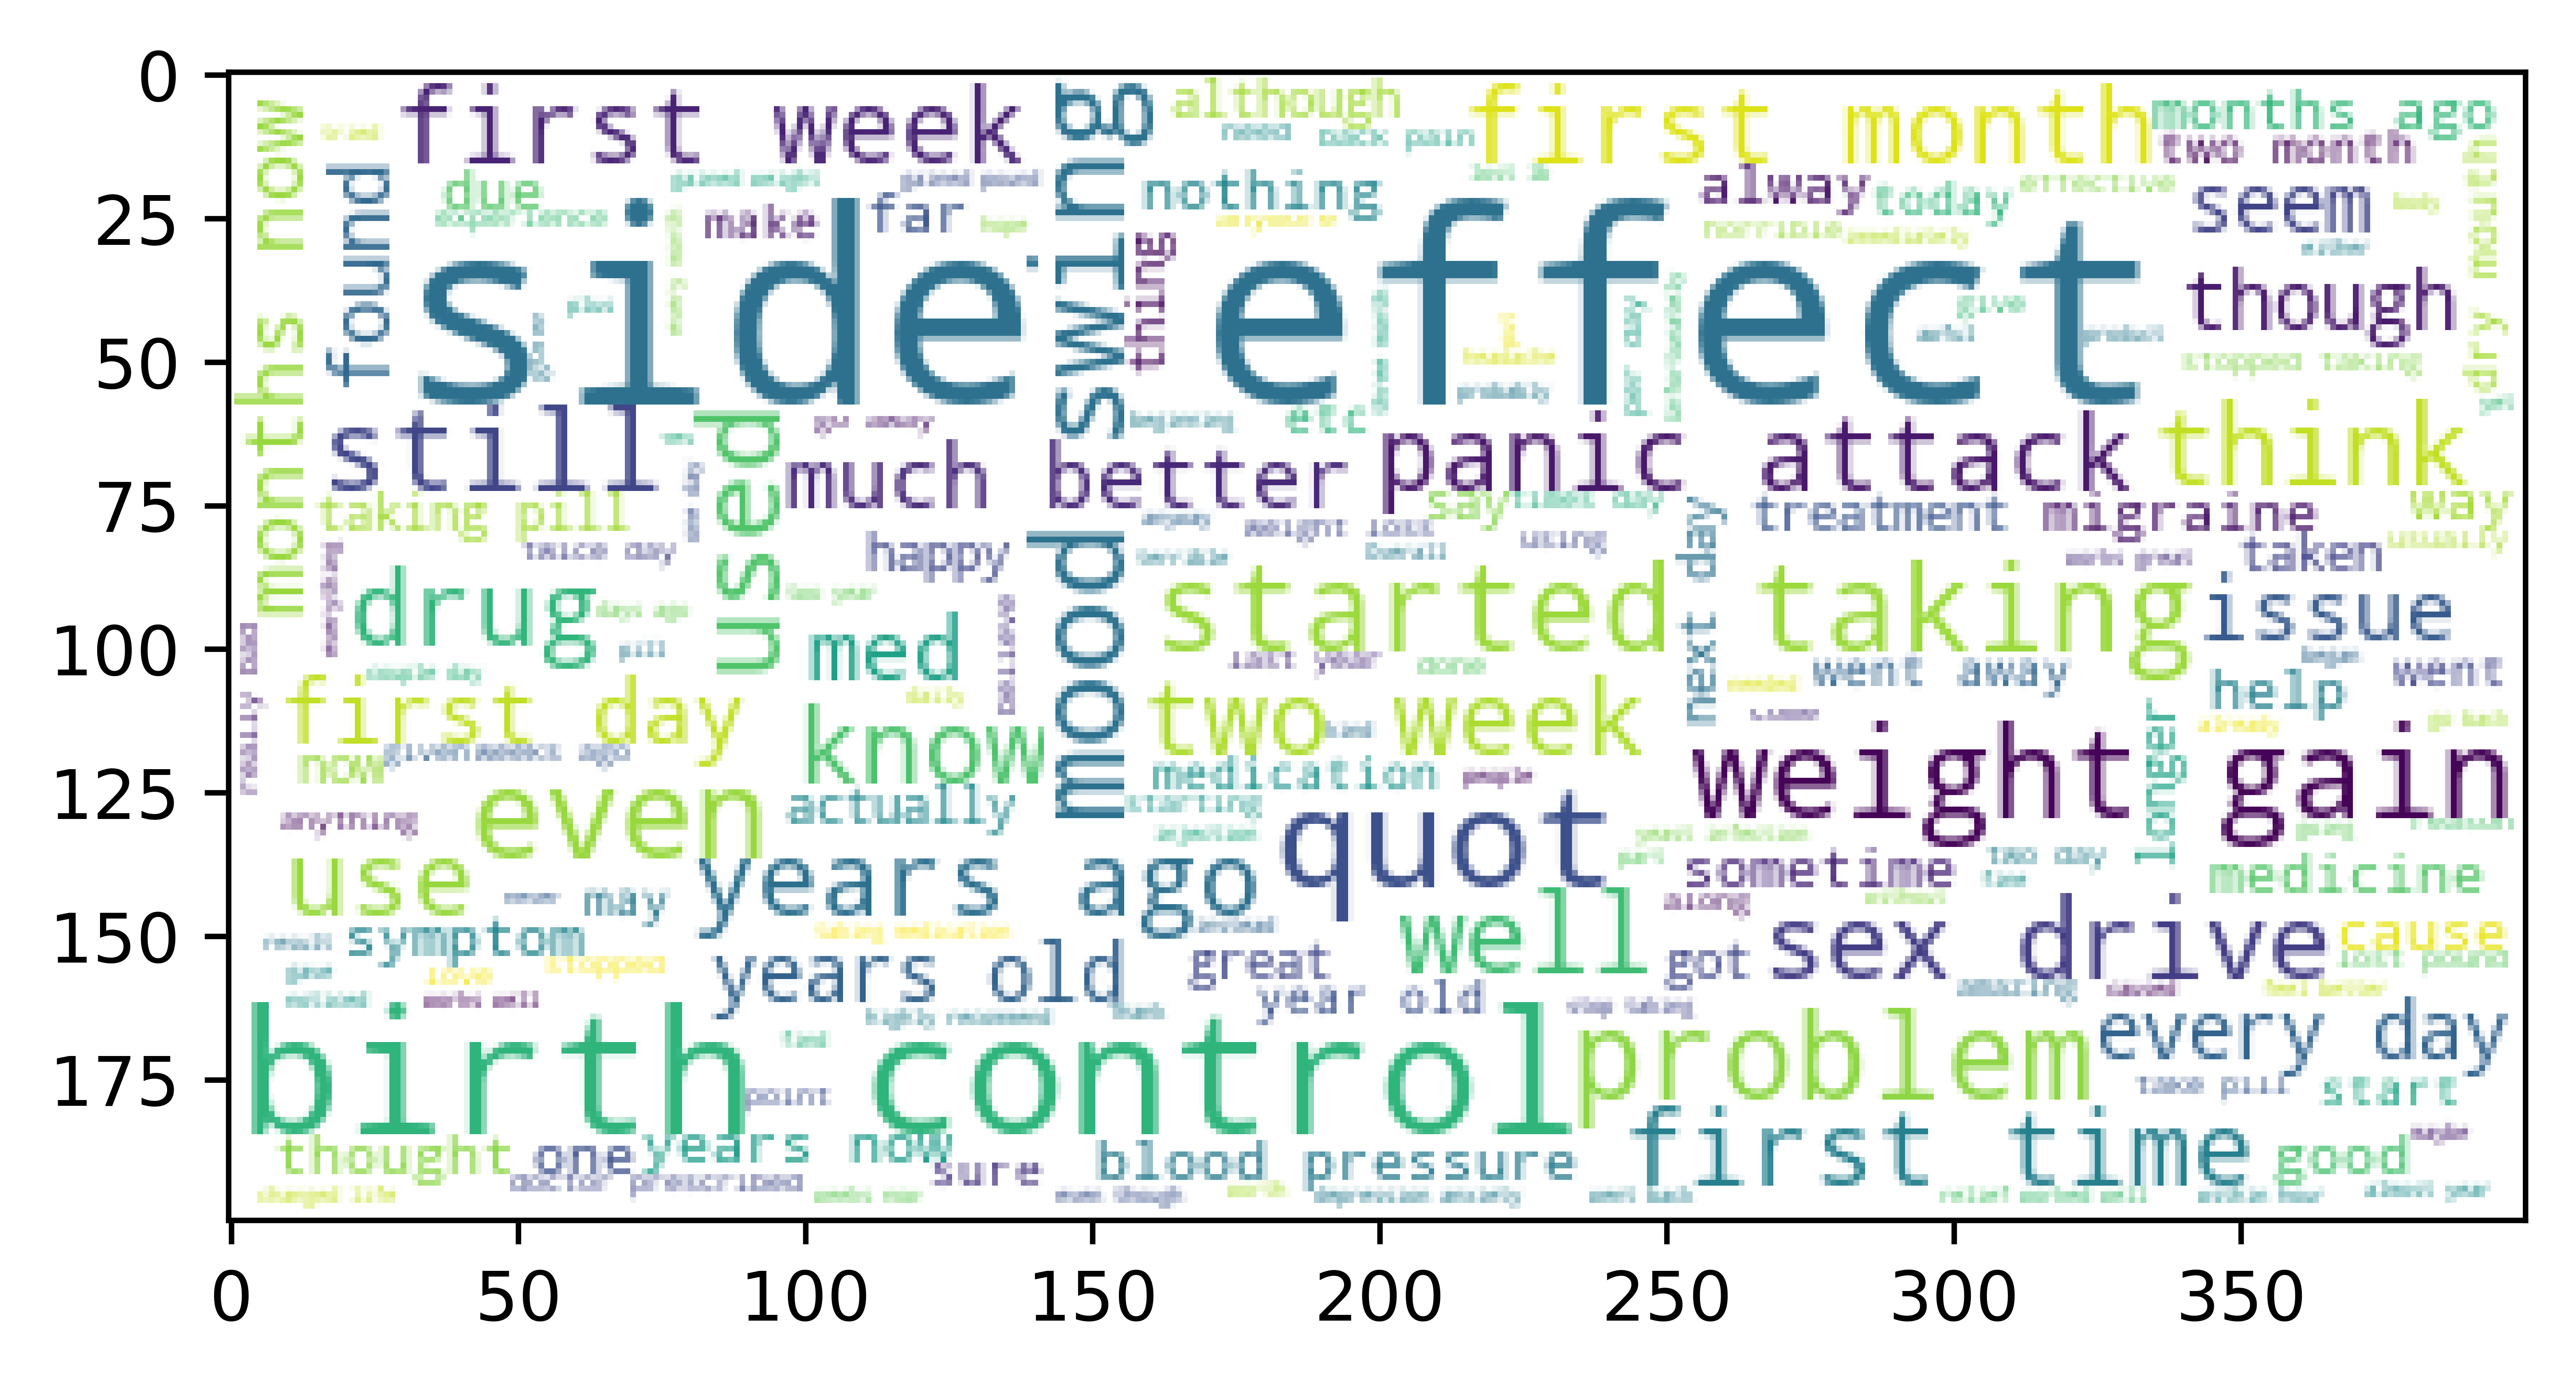

In [16]:
wc = WordCloud(stopwords=STOPWORDS,background_color='white').generate(' '.join(df_train['review']))
plt.figure(dpi=1200)
plt.imshow(wc)

## Word cloud for top100 most helpful and un-helpful review

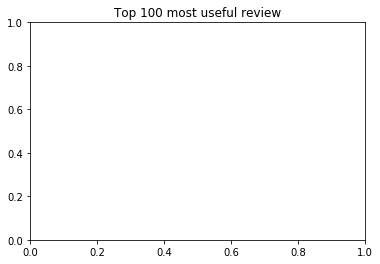

In [22]:
reviews_by_comments = df_train.sort_values(by="usefulCount")

top_100 = reviews_by_comments.tail(100)
bottom_100 =reviews_by_comments.head(100)

wc1 = WordCloud(width=600, height=300,stopwords=STOPWORDS,background_color='white').generate(' '.join(top_100['review']))
plt.title("Top 100 most useful review")
plt.figure(figsize=(15, 8), dpi = 1200)
plt.imshow(wc1)


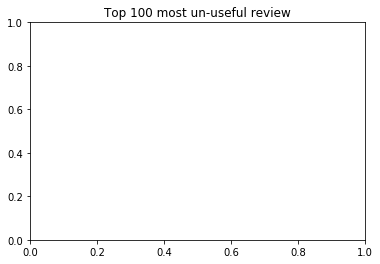

In [35]:

wc = WordCloud(width=600, height=300, stopwords=STOPWORDS,background_color='white').generate(' '.join(bottom_100['review']))
plt.title("Top 100 most un-useful review")
plt.figure(figsize=(15,8), dpi=1200)
plt.imshow(wc)


## Top five conditions in our dataset
- we can see the maximum number of condition is regarding birth-control

In [55]:
df_train['condition'].value_counts().sort_values(ascending=False)[0:5]

Birth Control    28788
Depression        9069
Pain              6145
Anxiety           5904
Acne              5588
Name: condition, dtype: int64

c:\users\sarthak\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


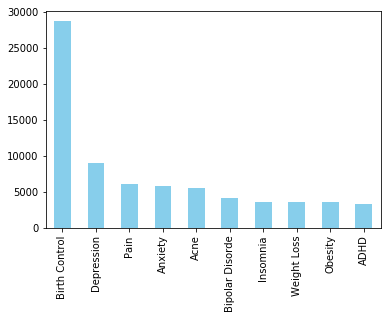

In [33]:
#Plotting a graph of top 10 conditions
bar_data = df_train['condition'].value_counts().sort_values(ascending=False)[0:10]
ax = bar_data.plot.bar(color='skyblue',stacked=True)
plt.axes(ax)
plt.show()

## Count Vs Rating 
- The graph is a representation of distribution of classes

Text(0.5,1,'Count of rating values')

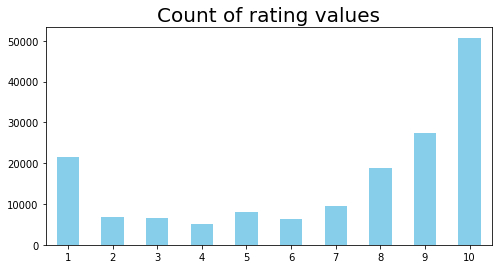

In [30]:
rating = df_train['rating'].value_counts().sort_index()
rating.plot(kind="bar", figsize = (8,4), fontsize = 10,color="skyblue")
plt.xticks(rotation=0)
plt.title("Count of rating values", fontsize = 20)

## Top 10 popular drugs

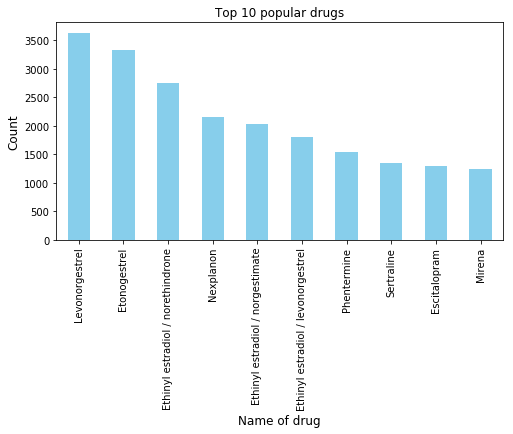

In [58]:
drug = df_train['drugName'].value_counts()

plt.figure(figsize=(20,6))
drug[:10].plot(kind="bar", figsize = (8,4), fontsize = 10,color="skyblue")

plt.xlabel('Name of drug', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Top 10 popular drugs")
plt.xticks(rotation=90)
plt.show()

## Least popular 10 drugs

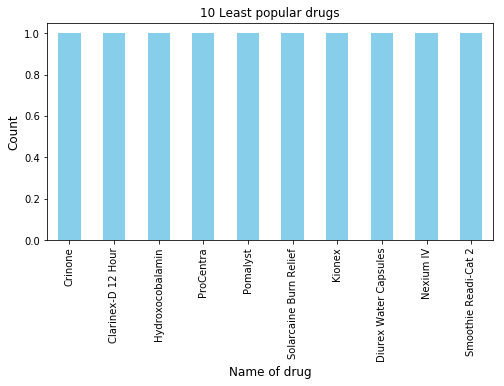

In [61]:
drug[-10:].plot(kind="bar", figsize = (8,4), fontsize = 10,color="skyblue")

plt.xlabel('Name of drug', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("10 Least popular drugs")
plt.xticks(rotation=90)
plt.show()

# Summarize our Dataset

In [20]:
%%time
import multiprocessing as mp

print("Number of processors using: ", mp.cpu_count()-1)
pool = mp.Pool(mp.cpu_count()-1)
rows,_ = df_train.shape


print("starting summarization of training set")
summary_v=np.vectorize(summarize_review.summarize)
short_review = pool.map(summary_v, df_train.review.values)
pool.close()
print("Summarization of training set COMPLETE....")

print("starting summarization of test set")
pool = mp.Pool(mp.cpu_count())
short_review_test = pool.map(summary_v, df_test.review.values)
pool.close()
print("Summarization of test set COMPLETE....")


df_train["summarize"] = np.array(short_review)
df_test["summarize"] = np.array(short_review_test)

Number of processors using:  7
starting summarization of training set
Summarization of training set COMPLETE....
starting summarization of test set
Summarization of test set COMPLETE....
Wall time: 7min 37s


# Create sentiment column 
- we create sentiment column using VADER sentiment analyzer as ground truth

In [21]:
%%time

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
# Create list (cast to array) of compound polarity sentiment scores for reviews
sentiments = []
for i in df_train.summarize:
    if sid.polarity_scores(i).get('compound') < -0.5 :
        sentiments.append('negative')
    elif sid.polarity_scores(i).get('compound') < 0.5 :
        sentiments.append('neutral')
    elif sid.polarity_scores(i).get('compound') <= 1 :
        sentiments.append('positive')

sentiments_test = []
for i in df_test.summarize:
    if sid.polarity_scores(i).get('compound') < -0.5 :
        sentiments_test.append('negative')
    elif sid.polarity_scores(i).get('compound') < 0.5 :
        sentiments_test.append('neutral')
    elif sid.polarity_scores(i).get('compound') <= 1 :
        sentiments_test.append('positive')

sentiments_test = np.array(sentiments_test)
sentiments = np.array(sentiments)

df_train["sentiment"] = sentiments
df_test["sentiment"] = sentiments_test

Wall time: 2min 30s


## Graph for distribution of sentiment

Text(0.5,1,'Count of sentiment values')

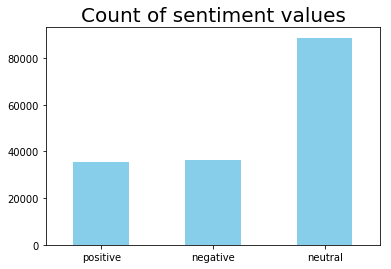

In [62]:
sentiment = df_train['sentiment'].value_counts().sort_values()
sentiment.plot(kind="bar", fontsize = 10,color="skyblue")
plt.xticks(rotation=0)
plt.title("Count of sentiment values", fontsize = 20)